# SKLEARN AUTOMATIC FEATURE SELECTION TECHNIQUES

this notebook focuses on implementing various feature selection techniques using the Scikit-learn library, specifically through statistical filter methods. It serves as a practical guide to selecting the most relevant features from a dataset to improve model performance and reduce overfitting.

The **Statistical Filter Methods** techniques explored in details in the previous notebook that called `202-02-feature-selection-part2.ipynb`. This earlier notebook provides foundational knowledge on various statistical methods, such as:
- Covariance Matrix
- Pearson’s Correlation
- Spearman’s Rank
- Kendall’s Rank
- ANOVA Correlation
- Chi-Squared Test
- Mutual Information

<a id="toc"></a>

<h3 class="list-group-item list-group-item-action active" data-toggle="list" role="tab" aria-controls="home">Table of Contents</h3>
  
* [SetUp](#1)    
    * [Import Dependancies](#1.1)
    * [Helper Functions](#1.2)
    * [Load Dataset](#1.3)
* [Feature Selection Techniques](#2)
    * [Select spacific number of features](#2.1) 
    * [Select spacific percentage of features](#2.2) 
    * [Select features that reduces hypothesis error](#2.3)
    * [Select features with general method](#2.4)

---
# <a id="1"><div style="text-align: center;">Setup</div></a> 

---


--- 
## <a id="1.1">Import Dependancies</a> 

In [53]:
import numpy as np 
import pandas as pd

%matplotlib inline
import matplotlib as mt
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (7, 6)
colors = sns.cubehelix_palette(20,reverse = True, light= 0.01,dark = 0.5, gamma= 0.7)
# sns.set_context('talk')
sns.set(style="whitegrid")
sns.set_palette(palette= sns.color_palette("RdBu",20))
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')

---
## <a id="1.2">Helper Functions</a> 


### Model Testing Function

The `Test_model` function serves as a **base model** that can be utilized as a baseline for testing any classification method by simply passing the feature set and target variable. 


1. **Data Splitting**: 
   - The function splits the dataset into training and testing sets using an 80-20 ratio. 
   - The `stratify` parameter ensures that the distribution of the target variable is maintained across both sets, which is crucial for imbalanced datasets.

2. **Model Training**: 
   - A logistic regression model is instantiated and trained on the training data. This can be easily modified to accommodate other models as needed.

3. **Make Predictions**: 
   - The function generates predictions for the test set, both in terms of class labels and predicted probabilities.

4. **Check Performance**:
   - The performance is evaluated through accuracy, a confusion matrix, a detailed classification report, and the AUC score


In [54]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

AUCs=[]

def Test_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)
    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Evaluate the model performance
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    auc = roc_auc_score(y_test, y_prob)
    print(f"\nAUC Score: {auc:.4f}")

    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return auc, accuracy, classification_report, confusion_matrix

---
## <a id="1.3">Load Dataset</a> 

### Read Data for binary classification problem

In [55]:
train_data = pd.read_csv('./datasets/santander-customer-satisfaction/train.csv', nrows=35000)
test_data = pd.read_csv('./datasets/santander-customer-satisfaction/test.csv', nrows=1500)
train_data.head(5)

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [56]:
y_train = train_data['TARGET']
y_train.nunique()

2

In [57]:
X_train = train_data.drop(labels=['TARGET'], axis = 1)
X_train.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016


---
# <a id="2"><div style="text-align: center;">Feature Selection Methods</div></a> 

---


Univariate feature selection methods works by selecting the best features based on univariate statistical tests like ANOVA.

1. **Select spacific number of features**:

Selects the top k features based on their statistical significance. Useful when you have a priori knowledge or constraints on the number of features to select.

2. **Select spacific percentage of features**: 

Select features based on percentile of the highest scores.

3. **Select features that reduces hypothesis error**:

   - Based on False Positive Rate
   - Based on False Discovery Rate
   - Family wise error

4. **Flexible Approach** 

In a complex dataset with mixed data types, you might use custom scoring functions to prioritize features based on domain knowledge and model requirements.


---
## <a id='1.1'>1.1  Select spacific number of features</a>


Using `SelectKBest` from [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest), you need to select the suitable statistical method according to the type of feature. The following code snippet will apply to all features in the dataset; I will not select the appropriate statistical method but will instead test all features across all methods.

#### **Parameters of `SelectKBest`**
* `score_func`: The custom scoring function (e.g., ).
    - **chi2**: Chi-squared stats of non-negative features for classification tasks.
    - **f_classif**: ANOVA F-value between label/feature for classification tasks.
    - **f_regression**: F-value between label/feature for regression tasks.
    - You can define custom one for pearson or spearman.

* `k`: The number of top features to select.


### **Feature Selection using Chi-squared**

In [58]:
non_neg_cols = X_train.loc[:, X_train.min() >=0].columns
print(len(non_neg_cols))
non_neg_cols[:5]

344


Index(['ID', 'var15', 'imp_ent_var16_ult1', 'imp_op_var39_comer_ult1',
       'imp_op_var39_comer_ult3'],
      dtype='object')

In [59]:
from sklearn.feature_selection import SelectKBest, chi2
KBest = 90
kbest_chi2 = SelectKBest(score_func=chi2, k=KBest)
kbest_chi2.fit(X_train[non_neg_cols], y_train)

SelectKBest(k=90, score_func=<function chi2 at 0x7f32c2deeee0>)

In [60]:
new_X_train = X_train.iloc[:, kbest_chi2.get_support(indices=True)]
new_X_train.shape

(35000, 90)

#### **Create Model with data after KBest Selection and chi2 anlysis**

Accuracy: 0.9604

Confusion Matrix:
[[6723    1]
 [ 276    0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      6724
           1       0.00      0.00      0.00       276

    accuracy                           0.96      7000
   macro avg       0.48      0.50      0.49      7000
weighted avg       0.92      0.96      0.94      7000


AUC Score: 0.5533


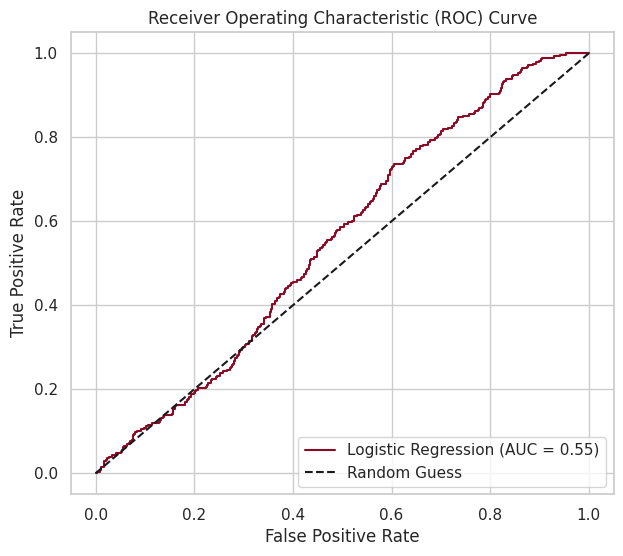

(0.5533283328591505,
 0.9604285714285714,
 <function sklearn.metrics._classification.classification_report(y_true, y_pred, *, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')>,
 <function sklearn.metrics._classification.confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)>)

In [61]:
Test_model(new_X_train, y_train)

### **Feature Selection using ANOVA**

In [62]:
from sklearn.feature_selection import f_classif, SelectKBest
KBest = 90
kbest_anova = SelectKBest(score_func=f_classif, k=KBest)
kbest_anova.fit(X_train, y_train)

/root/miniconda3/envs/nlp-env/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


SelectKBest(k=90)

In [63]:
new_X_train = X_train.iloc[:, kbest_anova.get_support(indices=True)]
new_X_train.shape

(35000, 90)

#### **Create Model with data after KBest Selection and  ANOVA**

Accuracy: 0.9606

Confusion Matrix:
[[6724    0]
 [ 276    0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      6724
           1       0.00      0.00      0.00       276

    accuracy                           0.96      7000
   macro avg       0.48      0.50      0.49      7000
weighted avg       0.92      0.96      0.94      7000


AUC Score: 0.6161


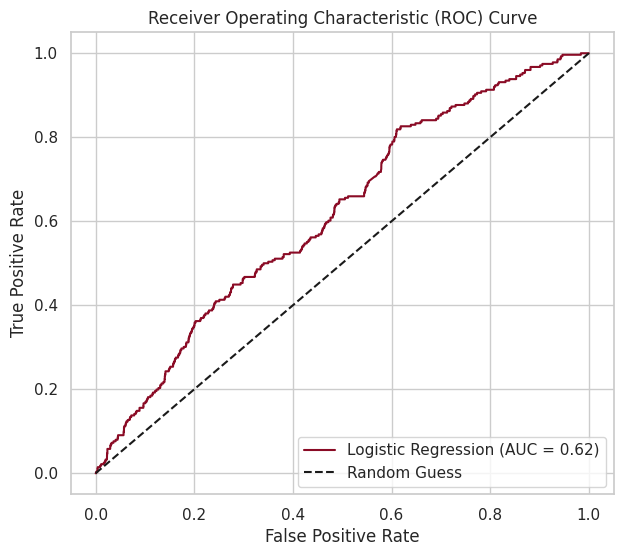

(0.6161052987783324,
 0.9605714285714285,
 <function sklearn.metrics._classification.classification_report(y_true, y_pred, *, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')>,
 <function sklearn.metrics._classification.confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)>)

In [64]:
Test_model(new_X_train, y_train)

### **Feature Selection using Persons Correlation**

In [65]:
from sklearn.feature_selection import SelectKBest
from scipy.stats import pearsonr

# Custom scoring function for Pearson's correlation
def pearson_correlation(X, y):
    scores = []
    for i in range(X.shape[1]):
        corr, _ = pearsonr(X[:, i], y)
        scores.append(abs(corr))  # Use absolute value for feature importance
    return np.array(scores)


In [66]:
KBest = 90
kbest_pearsons = SelectKBest(score_func=pearson_correlation, k=KBest)
new_X_train = kbest_pearsons.fit_transform(X_train, y_train)
new_X_train.shape

/root/miniconda3/envs/nlp-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


(35000, 90)

#### **Create Model with data after KBest Selection and Pearsons Correlation**

Accuracy: 0.9606

Confusion Matrix:
[[6724    0]
 [ 276    0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      6724
           1       0.00      0.00      0.00       276

    accuracy                           0.96      7000
   macro avg       0.48      0.50      0.49      7000
weighted avg       0.92      0.96      0.94      7000


AUC Score: 0.6161


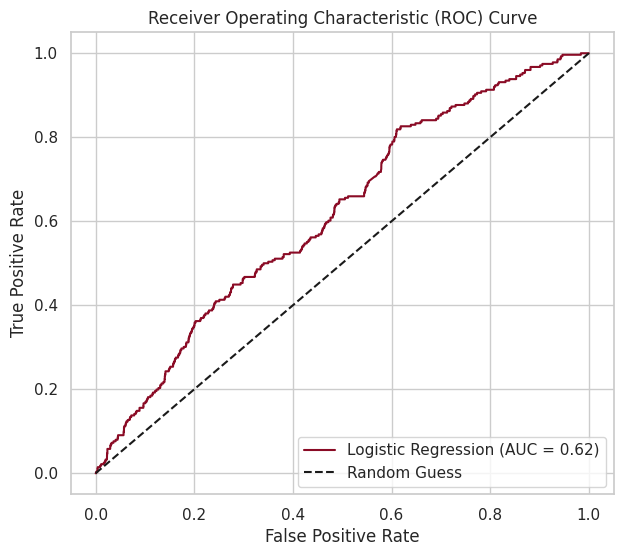

(0.6161052987783324,
 0.9605714285714285,
 <function sklearn.metrics._classification.classification_report(y_true, y_pred, *, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')>,
 <function sklearn.metrics._classification.confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)>)

In [67]:
Test_model(new_X_train, y_train)

### **Feature Selection using Spearman Rank**

In [68]:
from sklearn.feature_selection import SelectKBest
from scipy.stats import spearmanr

# Custom scoring function for Spearman's rank correlation
def spearman_correlation(X, y):
    scores = []
    for i in range(X.shape[1]):
        corr, _ = spearmanr(X[:, i], y)
        scores.append(abs(corr))  # Use absolute value for feature importance
    return np.array(scores)

In [69]:
KBest = 90
kbest_spearman = SelectKBest(score_func=spearman_correlation, k=KBest)
new_X_train = kbest_spearman.fit_transform(X_train, y_train)
new_X_train.shape

/root/miniconda3/envs/nlp-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


(35000, 90)

#### **Create Model with data after KBest Selection and Spearman Rank**

Accuracy: 0.9606

Confusion Matrix:
[[6724    0]
 [ 276    0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      6724
           1       0.00      0.00      0.00       276

    accuracy                           0.96      7000
   macro avg       0.48      0.50      0.49      7000
weighted avg       0.92      0.96      0.94      7000


AUC Score: 0.6137


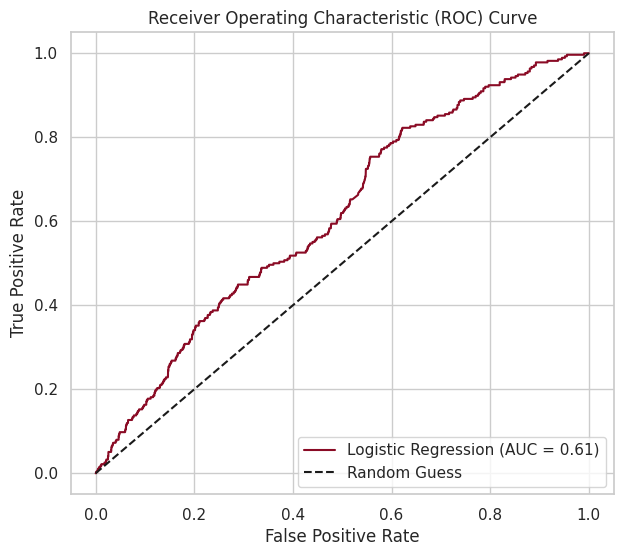

(0.6137117528386313,
 0.9605714285714285,
 <function sklearn.metrics._classification.classification_report(y_true, y_pred, *, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')>,
 <function sklearn.metrics._classification.confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)>)

In [70]:
Test_model(new_X_train, y_train)

---
## <a id='1.2'>1.2 Select spacific percentage of features</a>


`SelectPercentile` from [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html#sklearn.feature_selection.SelectPercentile) is used for feature selection by retaining a specified percentage of the top features based on their statistical significance. This method is beneficial in scenarios where the dataset has many features, and you want to avoid overfitting by selecting a manageable subset based on their performance metrics.

### **SelectPercentile using ANOVA**

In [71]:
from sklearn.feature_selection import SelectPercentile, f_classif

per = 30 # Percent of features to keep.
selectper = SelectPercentile(f_classif, percentile=per)
selectper.fit(X_train, y_train)

/root/miniconda3/envs/nlp-env/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


SelectPercentile(percentile=30)

In [72]:
selectper.get_support().sum()

111

In [73]:
new_X_train = X_train.iloc[:, selectper.get_support(indices=True)]

#### **Create Model with SelectPercentile by ANOVA**

Accuracy: 0.9606

Confusion Matrix:
[[6724    0]
 [ 276    0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      6724
           1       0.00      0.00      0.00       276

    accuracy                           0.96      7000
   macro avg       0.48      0.50      0.49      7000
weighted avg       0.92      0.96      0.94      7000


AUC Score: 0.6183


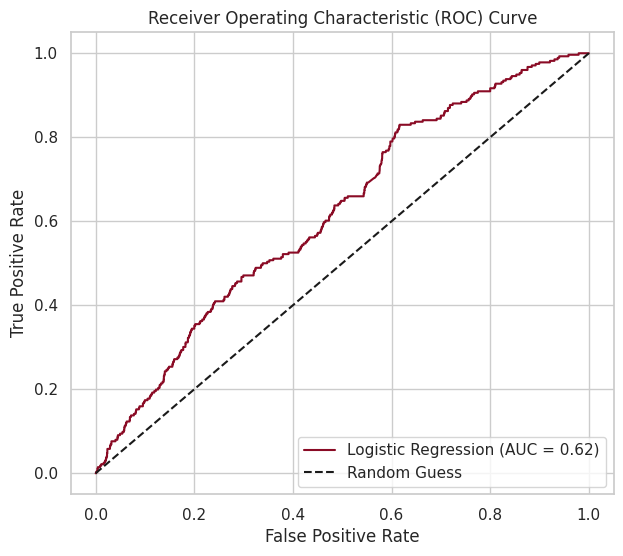

(0.6183080938709704,
 0.9605714285714285,
 <function sklearn.metrics._classification.classification_report(y_true, y_pred, *, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')>,
 <function sklearn.metrics._classification.confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)>)

In [74]:
Test_model(new_X_train, y_train)


### **SelectPercentile based on Mutual info**

Use [SelectPercentile](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html#sklearn.feature_selection.SelectPercentile) or [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest) from scikit-learn with the following parameters to apply this technique.

* **mutual_info_classif**: Mutual information for for classification tasks.
* **mutual_info_regression**: Mutual information for regression tasks.

In [75]:
selectMI = SelectPercentile(mutual_info_classif, percentile=60)
selectMI.fit(X_train, y_train)

SelectPercentile(percentile=60,
                 score_func=<function mutual_info_classif at 0x7f32c2de54c0>)

In [76]:
selectMI.get_support().sum()

222

In [77]:
new_X_train = X_train.iloc[:,selectMI.get_support(indices=True)]
new_X_train.shape

(35000, 222)

#### **Create Model with SelectPercentile by Mutual Information**

In [78]:
Test_model(X_train, y_train)

---
## <a id='1.3'>1.3 Select features that reduces hypothesis error</a>



**(a) Based on False Positive Rate**: [SelectFpr](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFpr.html) select features based on a false positive rate test. It refers to the likelihood of selecting a feature that is **not actually relevant** to the target variable.

- Use **FPR** when you want to minimize the risk of selecting irrelevant features.

**(b) Based on False Discovery Rate**:[SelectFdr](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFdr.html) is the same as `SelectFpr` but by controlling the  the proportion of falsely rejected null hypotheses.

- Use **FDR** when you want to control the proportion of false discoveries among the selected features (نفس فكره ال precision).

**(c) Family wise error:** [SelectFwe](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFwe.html) select features based on **family-wise error rate**. Applicable when you're concerned about overall error rates in multiple hypothesis tests.


### **False Positive Rate**


[SelectFpr](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFpr.html) select features based on a false positive rate test. `SelectFpr` focuses on controlling the false positive rate, which is the probability of incorrectly rejecting a true null hypothesis (Type I error). It refers to the likelihood of selecting a feature that is **not actually relevant** to the target variable.

- Minimize the risk of selecting irrelevant features (كتير reject مش).
- It operates by adjusting the threshold on the p-values of the features.
- `SelectFpr` allows you to set the desired level of significance (alpha) directly.


#### **Formula**:
$$\text{FPR} = \frac{\text{False Positives (FP)}}{\text{False Positives (FP)} + \text{True Negatives (TN)}}$$

في مجموعه كده فيتشر لاتنتمي للمشكله وفيتشر مش حلوه ... كام واحد فيهم انا غلطت وخدته كأنه مهم؟

Where:
- **False Positives (FP)**: Irrelevant features incorrectly selected as relevant.
- **True Positives (TP)**: Relevant features correctly identified as relevant.

#### **Practical Use Case**
- **Credit Risk Analysis**:
  - Use `SelectFpr` to remove features with insignificant impact on default rates.
  - This reduces the risk of approving high-risk applicants by focusing only on relevant features.

In [29]:
from sklearn.feature_selection import SelectFpr
selectfpr = SelectFpr(f_classif, alpha=0.05)
selectfpr.fit(X_train, y_train)

/root/miniconda3/envs/nlp-env/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


SelectFpr()

In [30]:
selectfpr.get_support().sum()

128

In [31]:
new_X_train = X_train.iloc[:, selectfpr.get_support(indices=True)]

##### **Create Model with SelectFpr by ANOVA**

Accuracy: 0.9606

Confusion Matrix:
[[6724    0]
 [ 276    0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      6724
           1       0.00      0.00      0.00       276

    accuracy                           0.96      7000
   macro avg       0.48      0.50      0.49      7000
weighted avg       0.92      0.96      0.94      7000


AUC Score: 0.6156


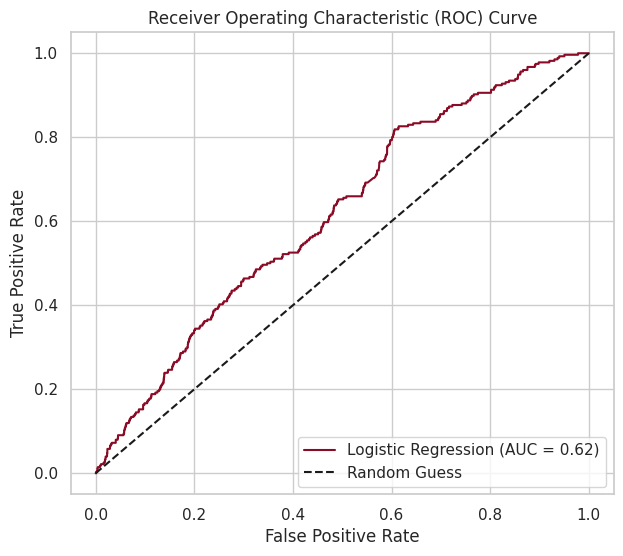

(0.6155820810594108,
 0.9605714285714285,
 <function sklearn.metrics._classification.classification_report(y_true, y_pred, *, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')>,
 <function sklearn.metrics._classification.confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)>)

In [32]:
Test_model(new_X_train, y_train)

### **False Discovery Rate**

The [SelectFdr](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFdr.html) is a statistical measure that represents the **proportion of false positives (incorrectly selected features) among all selected features**. Unlike the **False Positive Rate (FPR)**, which focuses on the probability of incorrectly rejecting a true null hypothesis, FDR focuses on the **proportion of errors among the discoveries (selected features)**.

- `SelectFdr` does not require you to specify the significance level (alpha) directly. Instead, it estimates the threshold based on the desired false discovery rate.

- `SelectFdr` is a feature selection method in scikit-learn that selects features while controlling the **False Discovery Rate**. It adjusts the p-values of the features using the **Benjamini-Hochberg procedure** to minimize the proportion of false discoveries.

#### **Formula**:
$$\text{FDR} = \frac{\text{False Positives (FP)}}{\text{False Positives (FP)} + \text{True Positives (TP)}}$$

في مجموعه كده فيتشر  انا قولت انها لاتنتمي للمشكله وفيتشر مش حلوه ... كام واحد فيهم انا غلطت وخدته كأنه مهم؟

Where:
- **False Positives (FP)**: Irrelevant features incorrectly selected as relevant.
- **True Positives (TP)**: Relevant features correctly identified as relevant.

#### **How Does SelectFdr Work?**

1. Each feature is tested for its relationship with the target variable using a statistical test (e.g., ANOVA F-test, chi-squared test).
2. A p-value is calculated for each feature.
3. The p-values are adjusted using the **Benjamini-Hochberg procedure** to control the FDR.
4. Features with adjusted p-values **less than or equal to `alpha`** are selected.

> By controlling the FDR, `SelectFdr` ensures that the proportion of false positives among the selected features is kept below a specified threshold.

#### **Practical Use Case**
- **Genomics**:
  - Use `SelectFdr` to identify genes associated with a disease while controlling the proportion of false discoveries.
- **Marketing**:
  - Use `SelectFdr` to select customer features that are truly predictive of purchase behavior, minimizing the risk of including irrelevant features.


In [49]:
from sklearn.feature_selection import SelectFdr
selectfdr = SelectFdr(f_classif)#, alpha=0.05)
selectfdr.fit(X_train, y_train)

/root/miniconda3/envs/nlp-env/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


SelectFdr()

In [50]:
selectfdr.get_support().sum()

102

In [51]:
new_X_train = X_train.iloc[:, selectfdr.get_support(indices=True)]

#### **Create Model with SelectFdr by ANOVA**

Accuracy: 0.9606

Confusion Matrix:
[[6724    0]
 [ 276    0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      6724
           1       0.00      0.00      0.00       276

    accuracy                           0.96      7000
   macro avg       0.48      0.50      0.49      7000
weighted avg       0.92      0.96      0.94      7000


AUC Score: 0.6168


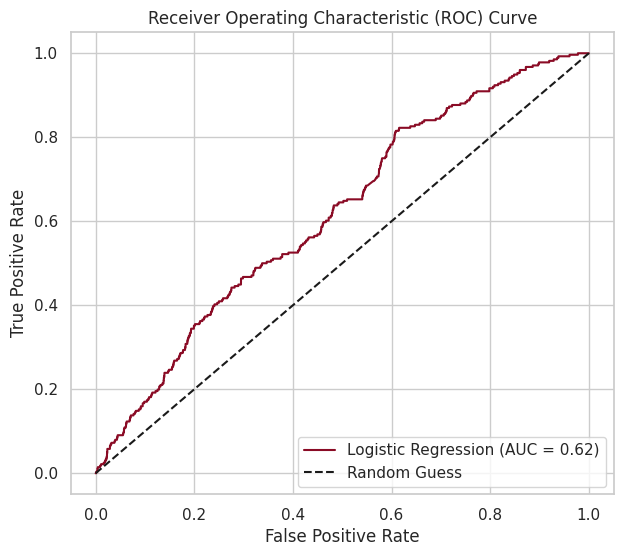

(0.6168020243298934,
 0.9605714285714285,
 <function sklearn.metrics._classification.classification_report(y_true, y_pred, *, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')>,
 <function sklearn.metrics._classification.confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)>)

In [52]:
Test_model(new_X_train, y_train)

### **Family wise errors**

[SelectFwe](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFwe.html) is a feature selection method in scikit-learn that selects features while controlling the **Family-Wise Error Rate**. It adjusts the p-values of the features using the **Bonferroni correction** to minimize the probability of making **at least one Type I error**.

In [45]:
from sklearn.feature_selection import SelectFwe

selectfwe = SelectFwe(f_classif, alpha=0.05)
selectfwe.fit(X_train, y_train)

/root/miniconda3/envs/nlp-env/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


SelectFwe()

In [46]:
selectfwe.get_support().sum()

76

In [47]:
new_X_train = X_train.iloc[:,selectfwe.get_support(indices=True)]
new_X_train.shape

(35000, 76)

#### **Create Model with SelectFwe Method**

Accuracy: 0.9599

Confusion Matrix:
[[6717    7]
 [ 274    2]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      6724
           1       0.22      0.01      0.01       276

    accuracy                           0.96      7000
   macro avg       0.59      0.50      0.50      7000
weighted avg       0.93      0.96      0.94      7000


AUC Score: 0.4008


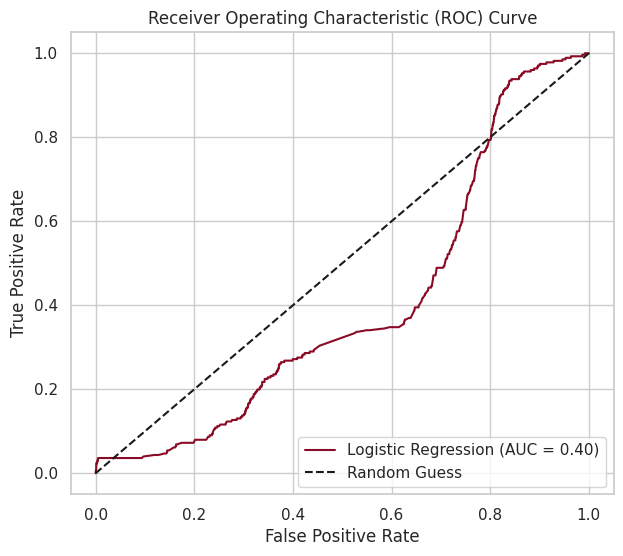

(0.4008480868875497,
 0.9598571428571429,
 <function sklearn.metrics._classification.classification_report(y_true, y_pred, *, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')>,
 <function sklearn.metrics._classification.confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)>)

In [48]:
Test_model(new_X_train, y_train)

---
## <a id='1.4'>1.4 Flexible Approach</a>


In a complex dataset with mixed data types, you might use [GenericUnivariateSelection](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.GenericUnivariateSelect.html) with custom scoring functions to prioritize features based on domain knowledge and model requirements.

   - **Example:** In a high-dimensional dataset, you could use it to experiment with different feature selection strategies such as combining chi-squared statistics with mutual information to capture both linear and non-linear relationships.
   
##### **GenericUnivariateSelection**:   
- `score_func`: callable, default=`f_classif`.
- `mode`: {‘percentile’, ‘k_best’, ‘fpr’, ‘fdr’, ‘fwe’}
- `param`: “all”, float, or int, default=`1e-5`} Parameter of the corresponding mode.



In [41]:
from sklearn.feature_selection import GenericUnivariateSelect, mutual_info_classif

selectgen = GenericUnivariateSelect(score_func=f_classif, mode='fwe', param=0.05)
selectgen.fit(X_train, y_train)

/root/miniconda3/envs/nlp-env/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


GenericUnivariateSelect(mode='fwe', param=0.05)

In [42]:
selectgen.get_support().sum()

76

In [43]:
new_X_train = X_train.iloc[:,selectgen.get_support(indices=True)]
new_X_train.shape

(35000, 76)

#### **Create Model with SelectFwe with Genaric Method**

Accuracy: 0.9599

Confusion Matrix:
[[6717    7]
 [ 274    2]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      6724
           1       0.22      0.01      0.01       276

    accuracy                           0.96      7000
   macro avg       0.59      0.50      0.50      7000
weighted avg       0.93      0.96      0.94      7000


AUC Score: 0.4008


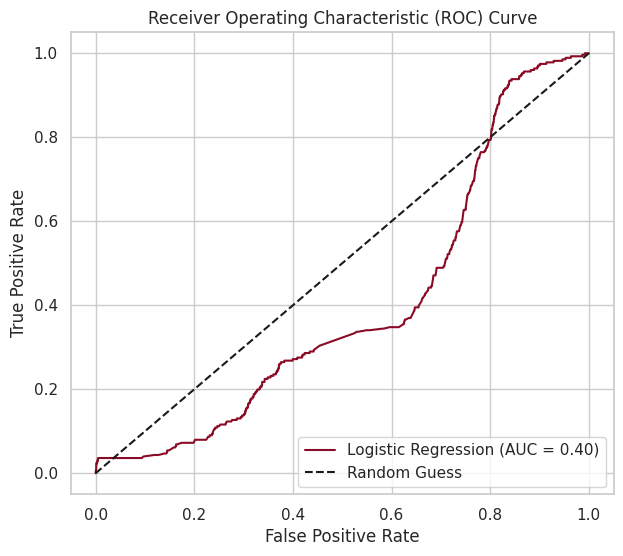

(0.4008480868875497,
 0.9598571428571429,
 <function sklearn.metrics._classification.classification_report(y_true, y_pred, *, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')>,
 <function sklearn.metrics._classification.confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)>)

In [44]:
Test_model(new_X_train, y_train)